In [1]:
import csv
import numpy as np
import pandas as pd
import os, re
import codecs
import spacy
nlp = spacy.load('en')
import gensim
from gensim.models import AuthorTopicModel
from gensim.corpora import Dictionary
import pickle
from matplotlib import pyplot as plt
import numpy as np
import matplotlib

In [2]:
papers = pd.read_csv('/Users/macbook/Master--Y2/IR/nips-papers/papers.csv')

#author with unique id
authors = pd.read_csv('/Users/macbook/Master--Y2/IR/nips-papers/authors.csv')
#paper id + author id
paper_author = pd.read_csv('/Users/macbook/Master--Y2/IR/nips-papers/paper_authors.csv')

#papers = papers.sort['year']
paper_text = papers['paper_text']
paper_title = papers['title']
del paper_author['id']


In [3]:
##change datafram to dictionary 
paperauthorlist = list(zip(paper_author['author_id'],paper_author['paper_id']))

paperauthordict={}
for item in paperauthorlist:
    author_id = item[0]
    paper_id =item[1]
    if not paperauthordict.get(author_id):
        paperauthordict[author_id]=[]
    paperauthordict[author_id].append(paper_id)
print(len(paperauthordict))

8653


In [4]:
authorlist = list(zip(authors['id'],authors['name']))

authordict={}
for item in authorlist:
    name_1 = re.sub('\s', '', item[1])
    name = name_1.lower()
    authordict[item[0]]=item[1]


In [5]:
#Construct author2doc
print(len(paperauthordict))
author2doc = dict((authordict[key], value) for (key, value) in paperauthordict.items())
print(len(author2doc))

8653
8595


In [6]:
# Use an integer ID in author2doc, instead of the IDs provided in the NIPS dataset.
# Mapping from ID of document in NIPS datast, to an integer ID.
author2doc=paperauthordict
doc_ids = list(set(papers['id']))
doc_id_dict = dict(zip(doc_ids, range(len(doc_ids))))
# Replace NIPS IDs by integer IDs.
for a, a_doc_ids in author2doc.items():
    for i, doc_id in enumerate(a_doc_ids):
        author2doc[a][i] = doc_id_dict[doc_id]



In [7]:
author2doc

{1: [0],
 2: [0],
 3: [1],
 4: [3,
  239,
  315,
  478,
  573,
  835,
  961,
  1143,
  1229,
  1542,
  1734,
  1685,
  1869,
  1957,
  2471,
  2887,
  3253,
  4451],
 5: [3, 617],
 6: [4, 98, 652],
 7: [5],
 8: [5],
 9: [6],
 10: [6],
 11: [6, 322, 469],
 12: [7, 357],
 13: [8, 23, 200, 1588],
 14: [20, 9],
 15: [10],
 16: [10, 103, 231, 549, 813, 760],
 17: [10, 106, 332],
 18: [15, 10, 82, 103, 284, 243, 407, 542, 641, 783],
 19: [11, 144, 271, 258],
 20: [12],
 21: [13, 237, 503, 572, 967, 861, 985, 1124, 1246, 1606, 1856],
 22: [13],
 23: [13],
 24: [14, 217],
 25: [15, 82],
 26: [142,
  333,
  1267,
  1344,
  1775,
  1811,
  2070,
  3693,
  4279,
  4737,
  4724,
  5012,
  5166],
 27: [16],
 28: [17, 233],
 29: [17],
 30: [17, 233],
 31: [17],
 32: [18],
 33: [19, 74, 254, 197, 463],
 34: [19],
 35: [19, 74, 197],
 36: [21],
 37: [21],
 38: [22],
 39: [22, 1958],
 40: [23, 39, 33, 126, 163, 147, 176, 229, 240, 190, 296],
 41: [24,
  276,
  273,
  212,
  293,
  301,
  401,
  365,
  

In [8]:
# Store data (serialize)
#with open('author2doc.pickle', 'wb') as handle:
#    pickle.dump(author2doc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
author2doc = pickle.load(open('author2doc.pickle', 'rb'))
print(len(author2doc))

8653


In [10]:
%%time
processed_docs = []    
#docs_1 = docs
STOPWORDS = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(1)','(2)','(3)','(4)','(5)',\
             '(i)','(ii)','(iii)','(iiii)','(v)']
for doc in nlp.pipe(paper_title, n_threads=4, batch_size=100):
    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities.
    
    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords and remove single letter, e.g.,'x','y'.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and len(token)>1]
    
     
    # Remove common words from a stopword list.
    doc = [token for token in doc if token not in STOPWORDS]
    #doc = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', doc)
    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
    
    processed_docs.append(doc)

docs = processed_docs




CPU times: user 2.63 s, sys: 17.5 ms, total: 2.65 s
Wall time: 2.65 s


In [11]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.     
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 20
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

_ =dictionary[1]  # This sort of "initializes" dictionary.id2token.

In [12]:
# Vectorize data.
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]



In [13]:
print('Number of authors: %d' % len(author2doc))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of authors: 8653
Number of unique tokens: 411
Number of documents: 6560


In [ ]:
%%time
model_list = []
for i in range(10):
    model = AuthorTopicModel(corpus=corpus, num_topics=10, id2word=dictionary.id2token, \
                     author2doc = author2doc,\
                    chunksize=100,\
                    passes=100, gamma_threshold=1e-10, \
                    eval_every=0, iterations=1, random_state=i)
    top_topics = model.top_topics(corpus)
    tc = sum([t[1] for t in top_topics])
    model_list.append((model, tc))

In [ ]:
model, tc = max(model_list, key=lambda x: x[1])
print('Topic coherence: %.3e' %tc)
# Save model.
model.save('/tmp/model.atmodel')
# Load model.

In [14]:
model = AuthorTopicModel.load('/tmp/model.atmodel')
model.show_topics(num_topics=10, num_words=10, log=False, formatted=True)

[(0,
  '0.144*"models" + 0.092*"inference" + 0.090*"bayesian" + 0.048*"high" + 0.041*"variational" + 0.033*"dimensional" + 0.032*"graphical" + 0.022*"systems" + 0.021*"framework" + 0.021*"monte"'),
 (1,
  '0.072*"analysis" + 0.062*"non" + 0.059*"fast" + 0.051*"method" + 0.050*"training" + 0.045*"probabilistic" + 0.044*"markov" + 0.040*"algorithms" + 0.034*"decision" + 0.033*"selection"'),
 (2,
  '0.072*"estimation" + 0.072*"learning" + 0.072*"sparse" + 0.069*"efficient" + 0.060*"information" + 0.042*"function" + 0.039*"random" + 0.034*"linear" + 0.032*"online" + 0.031*"complexity"'),
 (3,
  '0.121*"model" + 0.053*"large" + 0.046*"neuron" + 0.042*"mixture" + 0.042*"scale" + 0.040*"learning" + 0.038*"function" + 0.038*"application" + 0.035*"spike" + 0.031*"system"'),
 (4,
  '0.054*"dynamic" + 0.048*"recognition" + 0.041*"structure" + 0.040*"convex" + 0.036*"object" + 0.032*"representation" + 0.032*"analog" + 0.030*"learning" + 0.030*"model" + 0.030*"continuous"'),
 (5,
  '0.113*"learning

In [16]:
from pprint import pprint

def show_author(author_id):
    print('\n%s' % authordict[author_id])
    print('Docs:', model.author2doc[author_id])
    print('Topics:')
    pprint([(topic[0], topic[1]) for topic in model[author_id]])

In [17]:
show_author(7)


Gene A. Tagliarini
Docs: [5]
Topics:
[(0, 0.033342055112136081),
 (1, 0.033341322273298502),
 (2, 0.033379675959963322),
 (3, 0.36656180993986215),
 (4, 0.033344128864303199),
 (5, 0.033345152664162658),
 (6, 0.033341239929250879),
 (7, 0.36665498012818931),
 (8, 0.033341448890399014),
 (9, 0.033348186238435017)]


In [18]:
def get_top_words(model,k):
        top_words = model.get_topic_terms(k,10)
        word_id = [item[0] for item in top_words]
        word = [dictionary[item] for item in word_id]
        return word
def visualizetopicprob(author_id):

    array = np.zeros(10)

    for item in model[author_id]:
        topicid = item[0]
        prob = item[1]
        array[topicid] = prob

    fig = plt.figure(figsize=(12,6))
    plt.bar(range(10), array)
    plt.title(authordict[author_id])
    plt.xticks(np.arange(10), ['\n'.join(get_top_words(model, k)) for k in range(10)])
    plt.savefig('authortopic/author_id' + str(author_id) + '.png')
    plt.show()

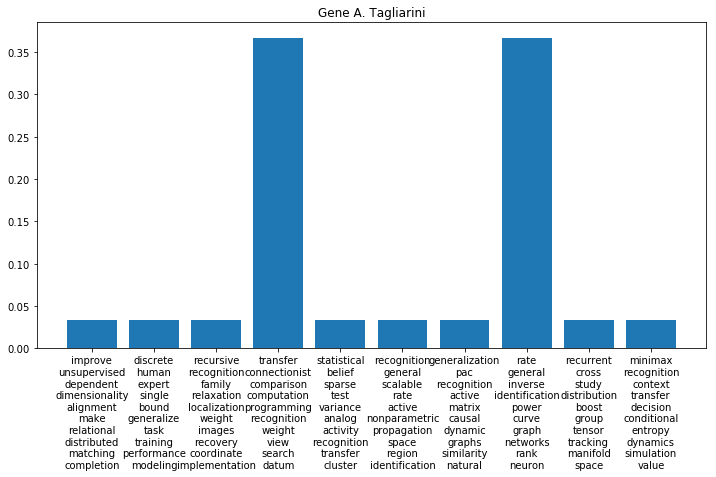

['improve unsupervised dependent dimensionality alignment make relational distributed matching completion',
 'discrete human expert single bound generalize task training performance modeling',
 'recursive recognition family relaxation localization weight images recovery coordinate implementation',
 'transfer connectionist comparison computation programming recognition weight view search datum',
 'statistical belief sparse test variance analog activity recognition transfer cluster',
 'recognition general scalable rate active nonparametric propagation space region identification',
 'generalization pac recognition active matrix causal dynamic graphs similarity natural',
 'rate general inverse identification power curve graph networks rank neuron',
 'recurrent cross study distribution boost group tensor tracking manifold space',
 'minimax recognition context transfer decision conditional entropy dynamics simulation value']

In [21]:
visualizetopicprob(7)
[' '.join(get_top_words(model, k)) for k in range(10)]

In [22]:
##find document topics
from sklearn import preprocessing
def getdocumenttopics(corpus):
    all_doc_topic=[]
    all_doc_topic_prob=[]
    for i in range(len(corpus)):
        topicseq=[]
        res = corpus[i]
        lst=[]
        for j in range(len(res)):
            topic = res[j][0]            
            count = res[j][1]
            #get the possibility 
            if model.get_term_topics(topic):
                a_topic =  model.get_term_topics(topic)[0][0]
                pos = count* model.get_term_topics(topic)[0][1]
                lst.append(pos)               
                topicseq.append(a_topic) 
        #Scale to [0,1]  
        lst_scaled= [item/np.sum(lst) for item in lst]
        doc_topic_prob = list(zip(topicseq,lst_scaled))
        all_doc_topic.append(topicseq)
        all_doc_topic_prob.append(doc_topic_prob) 
    return all_doc_topic, all_doc_topic_prob

all_topic, all_doc_topic_prob =getdocumenttopics(corpus)


from collections import Counter
for i in range(len(all_doc_topic_prob)):
    c = Counter()
    for topic, prob in all_doc_topic_prob[i]:
        c.update({topic: prob}) 
    all_doc_topic_prob[i] = list(c.items())
for i in range(len(all_topic)):
    all_topic[i]=list(set(all_topic[i]))



In [23]:
def topicseq(name):
    topics=[]
    for i,doc_id in enumerate(model.author2doc[name]):  
        doc_topics = all_topic[doc_id]
        topics.append(doc_topics) 
    return topics

In [24]:
# trends of research direction
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
def trendofresearch(author_id):
    # past current research direction
    #print(show_author(name))
    doc_ids = model.author2doc[author_id]
    topics = topicseq(author_id)
    #print(topics)
    length = len(topics)
    #print('length:',length)
    flat_list = [item for sublist in topics for item in sublist]
    topic_dict = {x:flat_list.count(x) for x in set(flat_list)}
    #print('topic_dict:',topic_dict)
    major_topic=[]
    for topic, count in topic_dict.items():
        if count/length >0.5:
            major_topic.append(topic)
    if len(major_topic)>1:
        string = 'This author works on variety topics: '+ str(major_topic)
    if len(major_topic)==1:
        string = 'This author focus on one topic'+ str(major_topic)
    if len(major_topic)==0:
        string = 'This author changes topics frequentyly'
    
    return string

In [25]:
trendofresearch(191)

'This author changes topics frequentyly'

In [26]:
## plot pie chart or radar chart to visualize the distribution of the topics for each author    

import pygal
def visualizetopicdistribution(name):
    radar_chart = pygal.Radar()
    radar_chart.title = 'Topic distribution For Author' + authordict[name]
    res = model[name]
    topic_seq = ['topic' + ' ' + str(i) for i in range(10)]

    topic_prob = np.zeros(10)
    for i in range(len(res)):
        topic = res[i][0]
        prob = res[i][1]
        topic_prob[topic] = prob
    doc_ids = model.author2doc[name]
    topics = topicseq(name)
    length = len(topics)

    flat_list = [item for sublist in topics for item in sublist]
    topic_dict = {x:flat_list.count(x) for x in set(flat_list)}
    topic_prob_1 = np.zeros(10)
    for topic, value in topic_dict.items():
        topic_prob_1[topic]=value/sum(topic_dict.values())


    radar_chart.x_labels = topic_seq
    radar_chart.add('Topics proabablity by ATM', topic_prob)
    radar_chart.add('Topics proabablity by Frequency', topic_prob_1)
    radar_chart.render_to_file('radar_chart.svg')



In [27]:
visualizetopicdistribution(7)

In [28]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
smallest_author = 1  # Ignore authors with documents less than this.
authors = [model.author2id[a] for a in model.author2id.keys() if len(model.author2doc[a]) >= smallest_author]
_ = tsne.fit_transform(model.state.gamma[authors, :])  # Result stored in tsne.embedding_

# Tell Bokeh to display plots inside the notebook.
from bokeh.io import output_notebook
output_notebook()

from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
            author_sizes=author_sizes,
            radii=radii,
        )
    )

# Add author names and sizes to mouse-over info.
hover = HoverTool(
        tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
        ]
    )

p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
show(p)

Loading BokehJS ...

CPU times: user 3min 5s, sys: 15.4 s, total: 3min 20s
Wall time: 3min 20s


In [29]:
#author with unique id
authors = pd.read_csv('/Users/macbook/Master--Y2/IR/nips-papers/authors.csv')
authorlist = list(zip(authors['id'],authors['name']))

authordict={}
for item in authorlist:
    name_1 = re.sub('\s', '', item[1])
    name = name_1.lower()
    authordict[item[0]]=name
authordict

{1: 'hisashisuzuki',
 2: 'suguruarimoto',
 3: 'philipa.chou',
 4: 'johnc.platt',
 5: 'alanh.barr',
 6: 'ralphlinsker',
 7: 'genea.tagliarini',
 8: 'edwardw.page',
 9: 'kenhsu',
 10: 'davidbrady',
 11: 'demetripsaltis',
 12: 'frankh.eeckman',
 13: 'amirf.atiya',
 14: 'christopherl.scofield',
 15: 'stuartmackie',
 16: 'hanspetergraf',
 17: 'danielb.schwartz',
 18: 'johns.denker',
 19: 'manoelfernandotenorio',
 20: 'paologaudiano',
 21: 'c.leegiles',
 22: 'r.d.griffin',
 23: 't.maxwell',
 24: 'eberharde.fetz',
 25: 'bens.wittner',
 26: 'tomasopoggio',
 27: 'anyac.hurlbert',
 28: 'alexandermoopenn',
 29: 'h.langenbacher',
 30: 'a.p.thakoor',
 31: 's.k.khanna',
 32: 'harrisonmonfookleong',
 33: 'lese.atlas',
 34: 'toshiteruhomma',
 35: 'robertj.marksii',
 36: 'darryld.coon',
 37: 'a.g.unilperera',
 38: 'alexandersinger',
 39: 'johnp.donoghue',
 40: 'jamesm.bower',
 41: 'christofkoch',
 42: 'jinluo',
 43: 'carvermead',
 44: 'jameshutchinson',
 45: 'williamy.huang',
 46: 'richardp.lippmann',


In [30]:
##Upload result
for id, name in authordict.items():
    topics = model[id]
    trend = trendofresearch(id)
    authordict[id] = (name, topics, trend)
authordict

{1: ('hisashisuzuki',
  [(0, 0.033338233455256168),
   (1, 0.033339211056096975),
   (2, 0.033338567884712011),
   (3, 0.033353816841000417),
   (4, 0.033338189553768126),
   (5, 0.033338675868338614),
   (6, 0.36663960345012192),
   (7, 0.36663470996828679),
   (8, 0.033340029162649769),
   (9, 0.033338962759769351)],
  'This author focus on one topic[3]'),
 2: ('suguruarimoto',
  [(0, 0.049998598962514233),
   (1, 0.049998090220776989),
   (2, 0.049998588953585596),
   (3, 0.54988293170339553),
   (4, 0.049996613282202153),
   (5, 0.049997163061921743),
   (6, 0.050061243737920036),
   (7, 0.050069836285525124),
   (8, 0.049999614408873683),
   (9, 0.04999731938328484)],
  'This author focus on one topic[3]'),
 3: ('philipa.chou',
  [(0, 0.10000060700643569),
   (3, 0.22058304430053266),
   (7, 0.28180589931816385),
   (9, 0.34303112798568097)],
  'This author works on variety topics: [1, 4, 5, 7]'),
 4: ('johnc.platt',
  [(0, 0.023964280664420134),
   (1, 0.19627911567285142),
   (2

In [31]:
# Store data (serialize)
with open('finaldict.pickle', 'wb') as handle:
     pickle.dump(authordict, handle, protocol=pickle.HIGHEST_PROTOCOL) 

In [32]:
finaldict = pickle.load(open('finaldict.pickle', 'rb'))

In [33]:
finaldict[1]

('hisashisuzuki',
 [(0, 0.033338233455256168),
  (1, 0.033339211056096975),
  (2, 0.033338567884712011),
  (3, 0.033353816841000417),
  (4, 0.033338189553768126),
  (5, 0.033338675868338614),
  (6, 0.36663960345012192),
  (7, 0.36663470996828679),
  (8, 0.033340029162649769),
  (9, 0.033338962759769351)],
 'This author focus on one topic[3]')

In [ ]:


#result = {}
#for key in (authordict.keys() | authorid2topic1.keys()):
#    if key in authordict: result.setdefault(key, []).append(authordict[key])
#    if key in authorid2topic1: result.setdefault(key, []).append(authorid2topic1[key])

author_cluster = pd.read_csv('/Users/macbook/Master--Y2/IR/author_cluster.csv')
author_clusterlist = list(zip(author_cluster['author_id'],author_cluster['cluster_id']))
author_clusterdict = {}
for item in author_clusterlist:
    author_clusterdict[item[0]] = item[1]

for key, value in finaldict.items():
    finaldict[key]= (value[0],value[1],value[2], author_clusterdict[key])
finaldict[1]

In [ ]:
authorscore = pickle.load(open('author_data.dat', 'rb'))
authorscore

In [ ]:
finalresult = {}
for key, value in finaldict.items():
    finalresult[key] = (value[0],value[1],value[2], value[3], \
                        authorscore[key][0],authorscore[key][1],authorscore[key][2])


In [ ]:
finalresult[1]
str([{2: 1.0}])

The code below is for loading our result into MongoDB.

In [ ]:
from sshtunnel import SSHTunnelForwarder
import pymongo
import pprint

def get_db():

    #Insert the pymongo library so we can talk to mongoDB via our driver
    from pymongo import MongoClient

    #Connect to db and authenticate
    client = MongoClient('109.238.10.185', 27000)
    db = client['webretrieval']
    db.authenticate('webretrieval', 'tue')

    #Return a database instance
    return db

In [ ]:
def add_author_id_topic(db, author_id, name,topics,trend, cluster, author_overall_score, cluster_score, workingtimes_with_coauthor):
    db.author_id_topic.insert(
        { 'author_id': str(author_id), 'author_name':name, 'topics': topics, 'trend': trend, 'cluster': str(cluster),\
        'author_overall_score':str(author_overall_score), 'cluster_score':str(cluster_score), \
         'workingtimes_with_coauthor': str(workingtimes_with_coauthor)}
    )




In [ ]:
db= get_db()
for authorid, value in finalresult.items():
        add_author_id_topic(db,authorid,value[0],value[1],value[2], value[3],value[4],value[5],value[6])

In [ ]:
import base64
for key,value in finalresult.items():
    trendofresearch(key)
    
    with open('myfig.png', "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
    abc=db.author_topic_png.insert({'author_id':str(key),"image":encoded_string})



In [ ]:
#def retrieve_image(request):
#    data = db.database_name.find()
#    data1 = json.loads(dumps(data))
#    img = data1[0]
#    img1 = img['image']
#    decode=img1.decode()
#    img_tag = '<img alt="sample" src="data:image/png;base64,{0}">'.format(decode)
#    return HttpResponse(img_tag)

In [ ]:
for key,value in authordict.items():
    visualizetopicprob(key)
    